### ЛАБОРАТОРНАЯ РАБОТА №3. ВСПЛЫТИЕ ПОДВОДНОЙ ЛОДКИ
**Цель работы**: изучить методы численного дифференцирования для
решения системы обыкновенных дифференциальных уравнений и применить их
на практике для решения практической задачи (определения траектории и точки
всплытия подводной лодки).



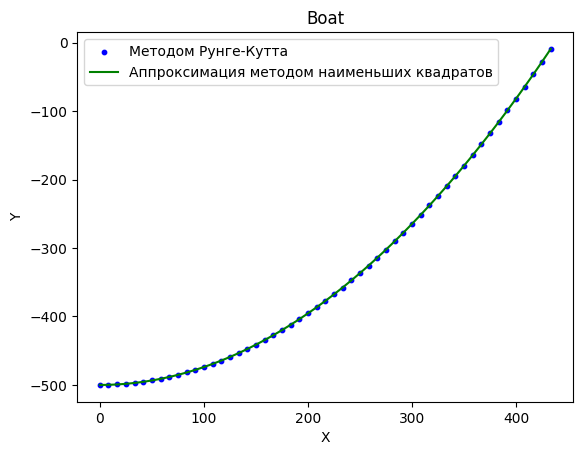

Время всплытия (T): [17.49635787]
Абсцисса точки всплытия (L): [437.40894669]


In [43]:
from typing import Callable, Tuple
import numpy as np
import matplotlib.pyplot as plt

# Дано
eta = 0.001
rho0 = 1000
g = 9.8
alpha = 0.01

# Задать самому
V = 900
S = 180
l = V/S
H = 500
rho1 = 750
v = 25

k = S / l

# Метод Рунге–Кутта 4 порядка
def rk4(f: Callable[[float, np.ndarray], np.ndarray], a: float, b: float, y0: np.ndarray, n: int) -> Tuple[np.ndarray, np.ndarray]:
    m = len(y0)
    h = (b - a) / n
    x = np.linspace(a + h, b, n)
    y = np.zeros((n, m))
    
    k1 = h * f(a, y0)
    k2 = h * f(a + h/2, y0 + k1/2)
    k3 = h * f(a + h/2, y0 + k2/2)
    k4 = h * f(a + h, y0 + k3)
    
    y[0, :] = y0 + k1/6 + k2/3 + k3/3 + k4/6
    
    for i in range(n - 1):
        k1 = h * f(x[i], y[i, :])
        k2 = h * f(x[i] + h/2, y[i, :] + k1/2)
        k3 = h * f(x[i] + h/2, y[i, :] + k2/2)
        k4 = h * f(x[i] + h, y[i, :] + k3)
        y[i + 1, :] = y[i, :] + k1/6 + k2/3 + k3/3 + k4/6
    
    x = np.concatenate(([a], x))
    y = np.concatenate((y0.reshape(1, m), y))
    
    return x, y


# Функция для системы уравнений
def submarine_sys(t: float, y: np.ndarray) -> np.ndarray:
    dy = y[1]
    dz = -(eta*k / (V*rho1)) * (1 + alpha*y[0]/H)*dy + g*(rho0/rho1-1)
    return np.array([dy, dz])

# Начальные условия
y0 = np.array([-H, 0])
a = 0
b = 100
n= 300

# Решение системы дифференциальных уравнений
solution: Tuple[np.ndarray, np.ndarray] = rk4(submarine_sys, a, b, y0, n)

# Убираем значения, где y1 >= 0
solution_x: np.ndarray = solution[0][solution[1][:, 0] <= 0]
solution_y: np.ndarray = solution[1][solution[1][:, 0] <= 0]

# Функция для аппроксимации методом наименьших квадратов
def custom_lm(x: np.ndarray, y: np.ndarray, degree: int) -> np.ndarray:
    n: int = len(x)
    X: np.ndarray = np.ones((n, degree + 1))
    for i in range(1, degree + 1):
        X[:, i] = x ** i
    coefficients: np.ndarray = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
    return coefficients

# Аппроксимация решения
# и получение коэффициентов полинома
degree = 2
c,b,a = custom_lm(solution_x, solution_y[:, 0], degree)

# Создание данных для аппроксимированной кривой
t_plot: np.ndarray = np.linspace(0, np.max(solution_x), 100)
y_plot: np.ndarray = a * t_plot**2 + b * t_plot + c

# Построение графика
plt.scatter(solution_x * v, solution_y[:, 0], color="blue", marker="o", s=10, label="Методом Рунге-Кутта")
plt.plot(t_plot * v, y_plot, color="green", label="Аппроксимация методом наименьших квадратов" )
plt.legend()
plt.title("Boat")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Определение времени всплытия и точки всплытия
def solve_quadratic(a: float, b: float, c: float, H: float) -> float:
    roots = np.roots([a, b, c - H])
    real_roots = np.real(roots[np.abs(np.imag(roots)) < 1e-6])
    return real_roots[real_roots > 0]

T = solve_quadratic(a, b, c, 0)
L = v * T

# Вывод значений
print("Время всплытия (T):", T)
print("Абсцисса точки всплытия (L):", L)